<center><strong><h1 style="color:green;"> 🌞 Proyecto reconstrucción de series de variables climáticas 🌦🌡 </h1></strong></center>
<center><strong><h2 style="color:black;"> Fernando Moreno (jofmorenore@unal.edu.co) </h2></strong></center>
<center><strong><h3 style="color:blue;"> Universidad Nacional de Colombia </h3></strong></center>
<center><strong><h3 style="color:blue;"> Junio 2023 </h3></strong></center>

La implementación presentada en la librería [gretel-synthetics](https://github.com/gretelai/gretel-synthetics), cambia de TensorFlow 1 a PyTorch (con posibles diferencias en los componentes subyacentes, como optimizadores, inicialización de parámetros, etc.), la principal diferencia es que el desarrollo actual sólo admite secuencias de longitud fija.

<h2 style="color:red;"> 📥 Importación de librerías</h2>

In [ ]:
! apt-get install git

In [ ]:
#!pip install tensorflow==2.11 # for LSTM

In [ ]:
#!pip install sdv==0.1.2 # for ACTGAN

In [ ]:
#!pip install torch==2.0 # for Timeseries DGAN

In [ ]:
#!git clone https://github.com/gretelai/gretel-synthetics.git

In [ ]:
#!pip install gretel-synthetics

In [ ]:
#!pip install pandas==1.5.3

In [1]:
import os
os.getcwd()

'/home/fm/Documents/Diplomado IA & DL'

In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
import torch

In [3]:
torch.cuda.is_available()

True

In [4]:
from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType, Normalization

In [5]:
pip freeze | grep pandas

pandas==1.5.3
Note: you may need to restart the kernel to use updated packages.


<h2 style="color:red;"> 🗃️ Carga de datos </h2>

In [ ]:
#!pip install rpy2==3.5.1
%load_ext rpy2.ipython

In [ ]:
%%R
#if("devtools" %in% row.names(installed.packages())==FALSE){ suppressMessages(install.packages("devtools"))}
#remotes::install_github("mikejohnson51/climateR")
#if("elevatr" %in% row.names(installed.packages())==FALSE){ suppressMessages(install.packages("elevatr"))}
#if("maps" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("maps"))}
#if("sf" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("sf"))}
#if("terra" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("terra"))}
#if("rgdal" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("rgdal"))}
#remotes::install_version('raster', version = '3.5-9')
#remotes::install_github("mikejohnson51/AOI")

In [8]:
%%R
library(climateR)
library(elevatr)
library(maps)
library(sf)
library(terra)
library(dplyr)
library(rgdal)
library(raster)
library(AOI)
library(ggplot2)
library(maps)
library(stringr)
library(lubridate)
library(openxlsx)

In [9]:
%%R
print(packageVersion("raster"))
packageVersion("terra")

[1] ‘3.5.9’
[1] ‘1.7.29’


## `climateR::getTerraClim`

In [10]:
%%R
# Load data ---------------------------------------------------------------
dpto_col <- st_read('gpkg/dpto.gpkg')

Reading layer `mpio' from data source 
  `/home/fm/Documents/Diplomado IA & DL/gpkg/dpto.gpkg' using driver `GPKG'
Simple feature collection with 33 features and 7 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -81.73562 ymin: -4.229406 xmax: -66.84722 ymax: 13.3945
Geodetic CRS:  WGS 84


In [11]:
%%R
ppt = getTerraClim(aoi_get(country = "Colombia"), varname = "ppt", startDate = "1981-01-01", endDate = '2020-01-01')
tmax = getTerraClim(aoi_get(country = "Colombia"), varname = 'tmax', startDate = '1981-01-01', endDate = '2020-06-30')
tmin = getTerraClim(aoi_get(country = "Colombia"), varname = 'tmin', startDate = '1981-01-01', endDate = '2020-06-30')
str(ppt)

List of 1
 $ ppt:S4 class 'SpatRaster' [package "terra"]


In [12]:
%%R
# [1,]    0.0  199.9 # [2,]  110.7 3693.4
ppt_df <- as.data.frame(ppt$ppt %>% raster::crop(dpto_col) %>% raster::mask(dpto_col), xy = TRUE) 
# [1,]    1.50   33.04 # [2,]    7.59   39.40
tmax_df <- as.data.frame(tmax$tmax %>% raster::crop(dpto_col) %>% raster::mask(dpto_col), xy = TRUE)
# [1,]   -6.65   23.71 # [2,]   -0.75   28.60
tmin_df <- as.data.frame(tmin$tmin %>% raster::crop(dpto_col) %>% raster::mask(dpto_col), xy = TRUE)

In [13]:
%%R
set.seed(123)
n = sample(1:nrow(ppt_df), 1)
pt = ppt_df[n,1:2]
pol = data.frame(matrix(c(pt +c(-0.1,-0.1),
         pt +c(-0.1,0.1),
         pt +c(0.1,0.1),
         pt +c(0.1,-0.1)
         ), nc = 2, byrow = T))
names(pol) = c("X", "Y")
pol = pol %>%
  st_as_sf(coords = c("X", "Y"), crs = 4326) %>%
  summarise(geometry = st_combine(geometry)) %>%
  st_cast("POLYGON")

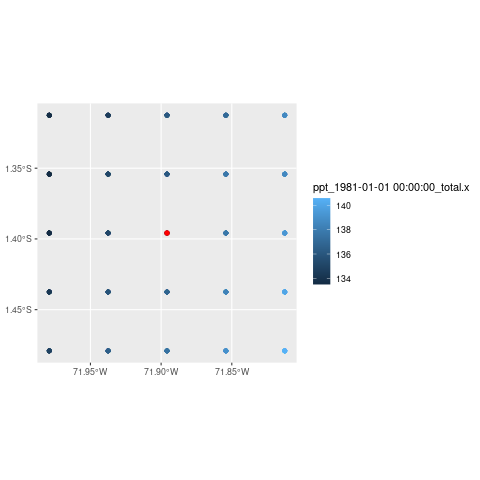

In [14]:
%%R
ppt_df2 <- st_as_sf(x = ppt_df, 
                   coords = c("x", "y"),
                   crs = 4326)

join_pptdf_pol = st_join(pol, ppt_df2)
ppt_df2 = st_join(ppt_df2, join_pptdf_pol[,1])
ppt_df2 = filter(ppt_df2, !is.na(`ppt_1981-01-01 00:00:00_total.y`)) %>% 
                  dplyr::select(-`ppt_1981-01-01 00:00:00_total.y`)
    
ggplot() + 
    geom_sf(data = ppt_df2, aes(fill = `ppt_1981-01-01 00:00:00_total.x`, col = `ppt_1981-01-01 00:00:00_total.x`)) +
    geom_sf(data = st_as_sf(pt, 
                            coords = c("x", "y"),
                            crs = 4326), fill = NA, col = 'red', lwd = 2)

In [15]:
%%R
tmax_df = st_as_sf(x = tmax_df, coords = c("x", "y"), crs = 4326)
tmin_df = st_as_sf(x = tmin_df, coords = c("x", "y"), crs = 4326)

tavg_df = (tmin_df[,-c(476)]+tmax_df[,-c(476)])/2
names(tavg_df) = str_replace(names(tavg_df),"tmin", "tavg")
dim(tavg_df)

[1] 54526   476


In [16]:
%%R
tavg_df$geometry = tavg_df$geometry %>% st_coordinates()
tavg_df$X = tavg_df$geometry[,1]
tavg_df$Y = tavg_df$geometry[,2]
tavg_df = st_as_sf(tavg_df, coords = c("X", "Y"), crs = 4326) 
dim(tavg_df)

[1] 54526   476


In [17]:
%%R
set.seed(1234)
i = sample(1:nrow(tavg_df), size =1 , replace = F)
j = sample(1:(ncol(tavg_df)-2), size =1 , replace = F)
print(tavg_df[i,j])
(tmin_df[i,j]+tmax_df[i,j])/2

Simple feature collection with 1 feature and 1 field
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -71.10417 ymin: 1.520833 xmax: -71.10417 ymax: 1.520833
Geodetic CRS:  WGS 84
      tavg_2014-10-01 00:18:13_total                   geometry
76432                          26.46 POINT (-71.10417 1.520833)
      tmin_2014-10-01 00:18:13_total                   geometry
76432                          26.46 POINT (-71.10417 1.520833)


## Estaciones Meteorológicas IDEAM

In [ ]:
%%R
library(readxl)
pcp_col = read_excel('pcp_col.xlsx')
tmed_col = read_excel('tmed_col2.xlsx')

In [19]:
%%R
sttns = dplyr::distinct(pcp_col, `X` , `Y`) %>% 
  dplyr::full_join(dplyr::distinct(tmed_col, `X` , `Y`), by=c("X" , "Y")) 

sttns.points <- st_as_sf(x = sttns, 
                         coords = c("X", "Y"),
                         crs = 4326)

print(head(sttns.points))

Simple feature collection with 6 features and 0 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -81.70389 ymin: 10.44725 xmax: -72.91769 ymax: 13.35
Geodetic CRS:  WGS 84
# A tibble: 6 × 1
              geometry
           <POINT [°]>
1 (-81.70389 12.58694)
2       (-81.35 13.35)
3 (-74.22889 11.12833)
4 (-75.51603 10.44725)
5 (-74.77978 10.88334)
6 (-72.91769 11.52822)


In [20]:
%%R
set.seed(12345)
n = sample(1:nrow(sttns.points), 1)
pt = sttns.points[n,]

pol = data.frame(matrix(c(pt$geometry[[1]] +c(-0.04,-0.04),
         pt$geometry[[1]] +c(-0.04,0.04),
         pt$geometry[[1]] +c(0.04,0.04),
         pt$geometry[[1]] +c(0.04,-0.04)
         ), nc = 2, byrow = F))
names(pol) = c("X", "Y")
pol = pol %>%
  st_as_sf(coords = c("X", "Y"), crs = 4326) %>%
  summarise(geometry = st_combine(geometry)) %>%
  st_cast("POLYGON")

In [21]:
%%R
set.seed(123456)
p = sample(1:ncol(tavg_df), size = 1, replace = FALSE)
names(tavg_df)[p]

[1] "tavg_1985-12-01 15:23:32_total"


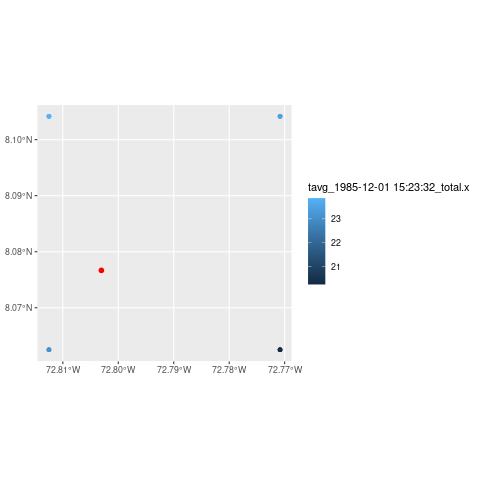

In [22]:
%%R
join_tavg_pol = st_join(pol, tavg_df)
tavg_df2 = st_join(tavg_df, join_tavg_pol)
tavg_df2 = filter(tavg_df2, !is.na(`tavg_1985-12-01 15:23:32_total.y`)) %>% 
                  dplyr::select(-`tavg_1985-12-01 15:23:32_total.y`)

ggplot() + 
    geom_sf(data = tavg_df2, aes(fill = `tavg_1985-12-01 15:23:32_total.x`, col = `tavg_1985-12-01 15:23:32_total.x`)) +
    geom_sf(data = pt, fill = NA, col = 'red', lwd = 2) 

In [23]:
%%R
join_ppt_pol = st_join(pol, st_as_sf(ppt_df, coords = c("x", "y"), crs = 4326))
ppt_df2 = st_join(st_as_sf(ppt_df, coords = c("x", "y"), crs = 4326), join_ppt_pol)
ppt_df2 = filter(ppt_df2, !is.na(`ppt_1985-12-01 17:13:50_total.y`)) %>% 
                  dplyr::select(-`ppt_1985-12-01 17:13:50_total.y`)

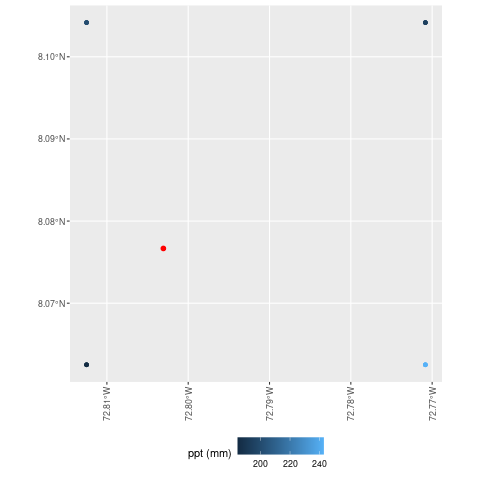

In [24]:
%%R    
q <- ggplot() + 
        geom_sf(data = rename(ppt_df2, "ppt (mm)"=`ppt_1985-12-01 17:13:50_total.x`), 
                aes(fill = `ppt (mm)`, col = `ppt (mm)`)) +
        geom_sf(data = pt, fill = NA, col = 'red', lwd = 2) +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), legend.position = "bottom")
q
#ggsave(filename="pixel_ppt.jpg", plot=q, width = 1600, height = 900, units = "px")

In [25]:
%%R
names_tavg_df = c(paste(sort(rep(1981:2020,12)), c(paste0(0,1:9),10:12), sep = "-"), "2021-01") 
names_tavg_df = names_tavg_df[!names_tavg_df %in% c("2020-07","2020-08","2020-09","2020-10","2020-11","2020-12","2021-01")] 
names_tavg_df2 = c(names_tavg_df, "geometry")
tail(names_tavg_df2)

[1] "2020-02"  "2020-03"  "2020-04"  "2020-05"  "2020-06"  "geometry"


In [26]:
%%R
ts_tavg_df2 = select_at(tavg_df2, vars(contains(".y"), "geometry")) %>% 
                distinct(geometry, .keep_all = TRUE) %>% as.data.frame() %>%
                `colnames<-`(names_tavg_df2) %>%
                tidyr::pivot_longer(!geometry,names_to="date", values_to = "tavg") %>% 
                tidyr::pivot_wider(names_from = geometry, values_from = tavg)%>% 
                `colnames<-`(c("date", "NW","NE", "SW", "SE")) %>% na.omit() %>%
                mutate(date = zoo::as.yearmon(date))
                
dim(ts_tavg_df2)                

[1] 474   5


In [27]:
%%R
names_ppt_df2 = names_tavg_df2[!names_tavg_df2 %in% c("1985-12","2020-07","2020-06","2020-05","2020-04","2020-03","2020-02","altitud")] 
ts_ppt_df2 = select_at(ppt_df2, vars(contains(".y"), "geometry")) %>% 
                distinct(geometry, .keep_all = TRUE) %>% as.data.frame() %>%
                `colnames<-`(names_ppt_df2) %>%
                tidyr::pivot_longer(!geometry,names_to="date", values_to = "ppt") %>% 
                tidyr::pivot_wider(names_from = geometry, values_from = ppt)%>% 
                `colnames<-`(c("date", "NW","NE", "SW", "SE")) %>% na.omit() %>%
                mutate(date = zoo::as.yearmon(date))
                
tail(ts_ppt_df2)       

# A tibble: 6 × 5
  date         NW    NE    SW    SE
  <yearmon> <dbl> <dbl> <dbl> <dbl>
1 ago 2019   29.2  29.2  29.2  29.2
2 sep 2019  230   230   230   230  
3 oct 2019  107.  107.  107.  107. 
4 nov 2019   69.6  69.6  69.6  69.6
5 dic 2019   37.7  37.7  37.7  37.7
6 ene 2020   55.9  55.9  55.9  55.9


In [28]:
%%R
ts_pt = pt %>% st_coordinates() %>% as.data.frame() %>%
        left_join(pcp_col) %>% st_as_sf(coords = c("X", "Y"), crs = 4326) %>% 
        dplyr::select(-ID) %>% as.data.frame() %>%
        tidyr::pivot_longer(!geometry, ,names_to="date", values_to = "ppt") %>%
        tidyr::pivot_wider(names_from = geometry, values_from = ppt)%>%
        `colnames<-`(c("date","point")) %>%
        mutate(date = zoo::as.yearmon(date))   
tail(ts_pt)        

Joining with `by = join_by(X, Y)`
# A tibble: 6 × 2
  date      point
  <yearmon> <dbl>
1 ago 2019   20.1
2 sep 2019  224. 
3 oct 2019  123. 
4 nov 2019   67.1
5 dic 2019   32.3
6 ene 2020   17.5


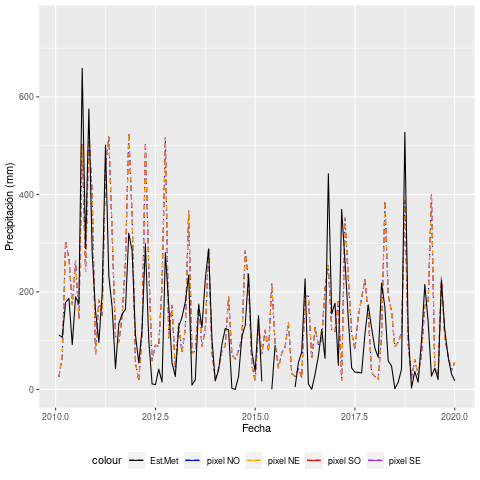

In [29]:
%%R
p <- ggplot(data=ts_ppt_df2[ts_ppt_df2$date> zoo::as.yearmon("2010-01"),]) +
        geom_line(aes(x = date, y = SE, color = "pixel SE"), linetype = "dashed") +
        geom_line(aes(x = date, y = SW, color = "pixel SO"), linetype = "dashed") +
        geom_line(aes(x = date, y = NW, color = "pixel NO"), linetype = "dotted") +
        geom_line(aes(x = date, y = NE, color = "pixel NE"), linetype = "dashed") +
        geom_line(data = ts_pt[ts_pt$date> zoo::as.yearmon("2010-01"),], aes(x=date, y=point, color="Est.Met"), linetype = "solid") +
        scale_color_manual(values=c("Est.Met"="black","pixel NO"="blue","pixel NE"="orange", "pixel SO"="red","pixel SE"="purple")) +
        #labs(color="Series de tiempo") +
        ylim(0,750)+
        labs(y = "Precipitación (mm)", x= "Fecha")+
        theme(legend.position = "bottom")
p
#ggsave(filename="plot_ts_ppt.jpg", plot=p, width = 1600, height = 900, units = "px")

In [30]:
%%R
a = NULL
b = NULL
for(i in 1:nrow(sttns.points)){
pt = sttns.points[i,]
# si es mayor o igual a cero quiere decir que todas las columnas son NAs
a[i] = st_join(pt, st_as_sf(x = pcp_col, 
                            coords = c("X", "Y"), crs = 4326)) %>% 
        is.na() %>% sum()-(ncol(pcp_col)-2)<0

b[i] = st_join(pt, st_as_sf(x = tmed_col, 
                            coords = c("X", "Y"),crs = 4326)) %>% 
        is.na() %>% sum()-(ncol(tmed_col)-2)<0
}

In [31]:
%%R
a %>% bind_cols(b) %>% `colnames<-`(c("ppt", "tmed")) %>% table()

New names:
• `` -> `...1`
• `` -> `...2`
       tmed
ppt     FALSE TRUE
  FALSE     0   10
  TRUE    648  198


Función que para cada estacion meteorológica:

    (1) obtenga los pixeles más cercanos 
    
    (2) los datos faltantes y valores atípicos sean reemplazados por las estimaciones 
    
    (3) devuelva la diferencia de las series $Y_t - E_t = S_t$

In [32]:
%%R
names_tavg_df = c(paste(sort(rep(1981:2020,12)), c(paste0(0,1:9),10:12), sep = "-"), "2021-01") 
names_tavg_df = names_tavg_df[!names_tavg_df %in% c("2020-08","2020-09","2020-10","2020-11","2020-12","2021-01")] 
names_tavg_df2 = c(names_tavg_df, "geometry")
names_ppt_df2 = names_tavg_df2[!names_tavg_df2 %in% c("2020-07","2020-06","2020-05","2020-04","2020-03","2020-02","altitud")] 

In [33]:
%%R
pixel4 = function(n){
    # selecciona 1 estación meteorológica
    pt = sttns.points[n,]
    # construye el polígono alrededor de la estación      
    pol = data.frame(matrix(c(pt$geometry[[1]] +c(-0.04,-0.04),
         pt$geometry[[1]] +c(-0.04,0.04),
         pt$geometry[[1]] +c(0.04,0.04),
         pt$geometry[[1]] +c(0.04,-0.04)
         ), nc = 2, byrow = F))
    
    names(pol) = c("X", "Y")
    
    pol = pol %>%
      st_as_sf(coords = c("X", "Y"), crs = 4326) %>%
      summarise(geometry = st_combine(geometry)) %>%
      st_cast("POLYGON")
    # determina si cruza a partir de si es mayor o igual a cero
    # quiere decir que todas las columnas son NAs
    flag_ppt = st_join(pt, st_as_sf(x = pcp_col, 
                                    coords = c("X", "Y"), crs = 4326)) %>% 
                is.na() %>% sum()-(ncol(pcp_col)-2)<0
    flag_tmed = st_join(pt, st_as_sf(x = tmed_col, 
                            coords = c("X", "Y"),crs = 4326)) %>% 
                is.na() %>% sum()-(ncol(tmed_col)-2)<0
    
    px = list()
    if(flag_ppt){
        # join para obtener los pixeles cercanos a la estación meteorológica
        join_ppt_pol = st_join(pol, st_as_sf(ppt_df, coords = c("x", "y"), crs = 4326))
        # join para obetener la precipitación de los pixeles
        ppt_df2 = st_join(st_as_sf(ppt_df, coords = c("x", "y"), crs = 4326), join_ppt_pol)%>%
            select_at(vars(contains("y"))) %>% na.omit() %>%
            distinct(geometry, .keep_all = TRUE) %>% as.data.frame() %>%
            `colnames<-`(names_ppt_df2) %>%
            tidyr::pivot_longer(!geometry,names_to="date", values_to = "tavg") %>% 
            tidyr::pivot_wider(names_from = geometry, values_from = tavg)%>% 
            mutate(date = zoo::as.yearmon(date))
        
        ts_pt = st_join(pt, st_as_sf(x = pcp_col, coords = c("X", "Y"),crs = 4326)) %>% 
                dplyr::select(-ID) %>% relocate(geometry, .after = last_col()) %>% 
                tidyr::pivot_longer(!geometry,names_to="date", values_to = "ppt") %>%
                mutate(date = zoo::as.yearmon(date))
        
        num_vars = names(ppt_df2)[sapply(ppt_df2, is.numeric) %>% as.vector()]
        
        ppt_df2 = inner_join(ppt_df2, ts_pt, by =c("date")) %>%
                    mutate(ppt2 = rowMeans(dplyr::select(., all_of(num_vars))),
                    ppt = ifelse(is.na(ppt)| ppt<0,ppt2, ppt)) %>% 
                    mutate(across(all_of(num_vars), ~ . - ppt))%>%  
                    dplyr::select(-c(ppt2, ppt)) %>%
                    tidyr::pivot_longer(cols = all_of(num_vars), names_to = "pixel", values_to = "ppt") %>%
                    tidyr::pivot_wider(names_from = date, values_from = ppt) %>% head()
        px[["ppt"]] = ppt_df2
    }
    if(flag_tmed){
        join_tavg_pol = st_join(pol, tavg_df)
        tavg_df2 = st_join(tavg_df, join_tavg_pol) %>%
            select_at(vars(contains("y"))) %>% na.omit() %>%
            distinct(geometry, .keep_all = TRUE)%>% as.data.frame() %>%
            `colnames<-`(names_tavg_df2)%>%
            tidyr::pivot_longer(!geometry,names_to="date", values_to = "tavg") %>% 
            tidyr::pivot_wider(names_from = geometry, values_from = tavg)%>% 
            mutate(date = zoo::as.yearmon(date))
        
        ts_pt = st_join(pt, st_as_sf(x = tmed_col, coords = c("X", "Y"),crs = 4326)) %>% 
                dplyr::select(-ID) %>% relocate(geometry, .after = last_col()) %>%                   
                tidyr::pivot_longer(!geometry,names_to="date", values_to = "tavg") %>%
                mutate(date = zoo::as.yearmon(date))
        
        num_vars = names(tavg_df2)[sapply(tavg_df2, is.numeric) %>% as.vector()]
        
        tavg_df2 = inner_join(tavg_df2, ts_pt, by =c("date")) %>%
                    mutate(tavg2 = rowMeans(dplyr::select(., all_of(num_vars))),
                           tavg = ifelse(is.na(tavg)| tavg<0,tavg2, tavg)) %>%
                    mutate(across(all_of(num_vars), ~ . - tavg)) %>%
                    dplyr::select(-c(tavg2, tavg)) %>%
                    tidyr::pivot_longer(cols = all_of(num_vars), names_to = "pixel", values_to = "tavg") %>%
                    tidyr::pivot_wider(names_from = date, values_from = tavg) %>% head()
        
        px[['tavg']] = tavg_df2
    }
    return(px)
}

In [34]:
%%R
px = list()
k = 1
for(i in 3:nrow(sttns.points)){
    #print(.)
    px[[k]] = pixel4(i)    
    k = k+1
}

In [228]:
%%R
ppt_px = px[[1]]$ppt
tavg_px = px[[1]]$tavg

for(i in 2:length(px)){
    if('ppt' %in% names(px[[i]]) ){
    ppt_px = ppt_px %>% bind_rows(px[[i]]$ppt)
    }
    if('tavg' %in% names(px[[i]]) ){
    tavg_px = tavg_px %>% bind_rows(px[[i]]$tavg)
    } 
}

In [229]:
%%R
ppt_px = distinct(ppt_px, pixel,.keep_all = TRUE)
print(dim(ppt_px))
tavg_px = distinct(tavg_px, pixel, .keep_all = TRUE)
print(dim(tavg_px))

[1] 2950  471
[1] 768 476


In [37]:
%%R
tavg_px$geometry = tavg_px$geometry %>% st_coordinates() #%>% as.data.frame()
tavg_px$X = tavg_px$geometry[,1]
tavg_px$Y = tavg_px$geometry[,2]

## `elevatr::get_elev_raster`

In [ ]:
%%R
# Download SRTM  ----------------------------------------------------------
srtm <- elevatr::get_elev_raster(locations = st_as_sf(tavg_px[,477:478], 
                                                      coords = c("X", "Y"), crs = 4326), z = 8)
srtm <- terra::rast(srtm)

In [39]:
%%R
tavg_px2 = st_as_sf(tavg_px, coords = c("X", "Y"), crs = 4326)
srtm <- as.data.frame(srtm %>% raster::crop(tavg_px2) %>% raster::mask(tavg_px2), xy = TRUE) %>%
        `colnames<-`(c("x", "y", "altitud"))
head(srtm)

                x        y altitud
661728  -72.48136 11.78175      -1
1042496 -72.91906 11.52734      13
1435671 -73.03122 11.26473      35
1509642 -72.36646 11.21548     120
1624239 -72.61540 11.13889      99
1640033 -74.22941 11.12795       8


In [40]:
%%R
range(srtm$altitud) # -1 5125

[1]   -1 3303


In [41]:
%%R
srtm = st_as_sf(srtm, coords = c("x", "y"),crs = 4326)

In [ ]:
%%R
for(i in 1:nrow(srtm)){
    pos = st_nearest_feature(srtm$geometry[i], st_as_sf(tavg_px, coords = c("X", "Y"), crs =4326)) %>% print()
    srtm$X[i] = tavg_px$X[pos]
    srtm$Y[i] = tavg_px$Y[pos]
}

In [43]:
%%R
tavg_px2 = st_join(st_as_sf(tavg_px, coords = c("X", "Y"), crs = 4326), 
                   srtm %>% as.data.frame() %>% dplyr::select(-geometry) %>% 
                   st_as_sf(coords=c("X", "Y"), crs = 4326))

# coordenadas planas
#tavg_px2 = st_join(st_as_sf(tavg_px, coords = c("X", "Y"), crs = 4326), 
#                   srtm %>% as.data.frame() %>% dplyr::select(-geometry) %>% 
#                   st_as_sf(coords=c("X", "Y"), crs = 4326)) %>%
#            st_transform(crs = 3857)

In [44]:
%%R
tavg_px2$altitud[is.na(tavg_px2$altitud)] = mean(tavg_px2$altitud, na.rm = T)

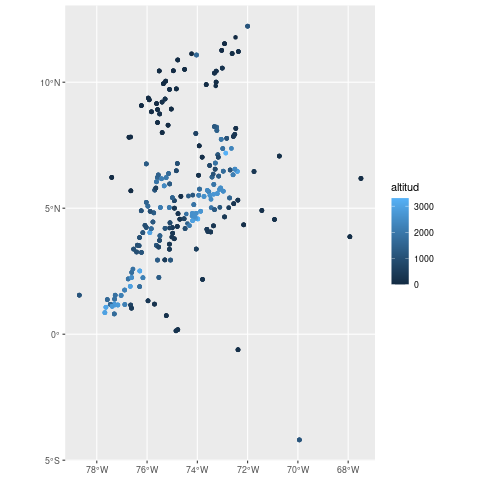

In [45]:
%%R
ggplot() +
    geom_sf(data=tavg_px2, aes(fill=`altitud`, col = `altitud`))

In [ ]:
#tavg_px2 = st_as_sf(tavg_px, coords = c("X", "Y"), crs = 4326) %>%
#             st_transform(crs = 3857) %>% 
#             st_coordinates() %>% as.data.frame()

In [46]:
%%R
tavg_px2$geometry = tavg_px2$geometry %>% st_coordinates() #%>% as.data.frame()
tavg_px2$lon = tavg_px2$geometry[,1]
tavg_px2$lat = tavg_px2$geometry[,2]

In [226]:
%%R
ppt_px$geometry = ppt_px$geometry %>% st_coordinates() #%>% as.data.frame()
ppt_px$lon = ppt_px$geometry[,1]
ppt_px$lat = ppt_px$geometry[,2]

In [47]:
%%R
sprintf("String: %f", tavg_px2$lon[1])

[1] "String: -74.228889"


In [48]:
%%R
write.xlsx(tavg_px2 , file = 'tavg_px.xlsx')

In [227]:
%%R
write.xlsx(ppt_px , file = 'ppt_px.xlsx')

<h2 style="color:red;"> 🔥 Estadísticas Descriptivas </h2>

In [ ]:
#! pip install openpyxl

In [49]:
tavg = pd.read_excel('tavg_px.xlsx')
tavg.drop(columns=['geometry', 'pixel', 'mar 2020', 'abr 2020', 'may 2020','jun 2020'], inplace=True)
tavg.head()

,ene 1981,feb 1981,mar 1981,abr 1981,may 1981,jun 1981,jul 1981,ago 1981,sep 1981,oct 1981,...,ago 2019,sep 2019,oct 2019,nov 2019,dic 2019,ene 2020,feb 2020,altitud,lon,lat
0,0.445,-0.205,0.03,-0.48,0.240,-0.550,0.08,-0.420,-0.12,-0.005,...,-0.3,-1.500000e-01,0.40,-0.1,-0.25,-0.6,-1.80,8.0,-74.228889,11.128333
1,0.445,-0.205,0.03,-0.48,0.240,-0.550,0.08,-0.420,-0.12,-0.005,...,-0.3,-1.500000e-01,0.40,-0.1,-0.25,-0.6,-1.80,8.0,-74.228889,11.128333
2,0.160,0.430,0.06,-0.17,-0.375,-0.525,-0.53,-0.175,-0.46,-0.285,...,0.3,3.552714e-15,0.05,0.3,0.10,0.1,-1.05,6.0,-75.516028,10.447250
3,0.160,0.430,0.06,-0.17,-0.375,-0.525,-0.53,-0.175,-0.46,-0.285,...,0.3,3.552714e-15,0.05,0.3,0.10,0.1,-1.05,6.0,-75.516028,10.447250
4,0.160,0.430,0.06,-0.17,-0.375,-0.525,-0.53,-0.175,-0.46,-0.285,...,0.3,3.552714e-15,0.05,0.3,0.10,0.1,-1.05,6.0,-75.516028,10.447250


In [230]:
ppt = pd.read_excel('ppt_px.xlsx')
ppt.drop(columns=['geometry', 'pixel'], inplace=True)
ppt.head()

,ene 1981,feb 1981,mar 1981,abr 1981,may 1981,jun 1981,jul 1981,ago 1981,sep 1981,oct 1981,...,jun 2019,jul 2019,ago 2019,sep 2019,oct 2019,nov 2019,dic 2019,ene 2020,lon,lat
0,-3.4,12.1,22.4,80.5,90.7,73.5,-2.2,51.8,133.2,84.7,...,17.4,-22.9,-23.3,-65.8,-16.6,6.8,2.3,0.8,-74.228889,11.128333
1,-3.4,12.1,22.4,80.5,90.7,73.5,-2.2,51.8,133.2,84.7,...,17.4,-22.9,-23.3,-65.8,-16.6,6.8,2.3,0.8,-74.228889,11.128333
2,-8.3,-3.6,6.9,190.4,129.5,30.9,-74.4,72.3,-53.7,60.1,...,9.6,-57.6,9.0,41.6,-35.0,-1.0,-0.1,1.4,-75.516028,10.447250
3,-8.3,-3.6,6.9,190.4,129.5,30.9,-74.4,72.3,-53.7,60.1,...,9.6,-57.6,9.0,41.6,-35.0,-1.0,-0.1,1.4,-75.516028,10.447250
4,-8.3,-3.6,6.9,190.4,129.5,30.9,-74.4,72.3,-53.7,60.1,...,9.6,-57.6,9.0,41.6,-35.0,-1.0,-0.1,1.4,-75.516028,10.447250


### Preparación de datos para el entrenamiento del modelo DGAN

In [50]:
# Extract numpy arrays for charts
tavg_attributes = tavg[["altitud", "lon", "lat"]].to_numpy()
print(tavg_attributes.shape)
tavg_features = np.expand_dims(tavg.iloc[:, 0:470].to_numpy(), axis=-1)
# Shape is now (# examples, # time points, # features)
print(tavg_features.shape)

(768, 3)
(768, 470, 1)


In [231]:
# Extract numpy arrays for charts
ppt_attributes = tavg[["lon", "lat"]].to_numpy()
print(ppt_attributes.shape)
ppt_features = np.expand_dims(ppt.iloc[:, 0:469].to_numpy(), axis=-1)
# Shape is now (# examples, # time points, # features)
print(ppt_features.shape)

(768, 2)
(2950, 469, 1)


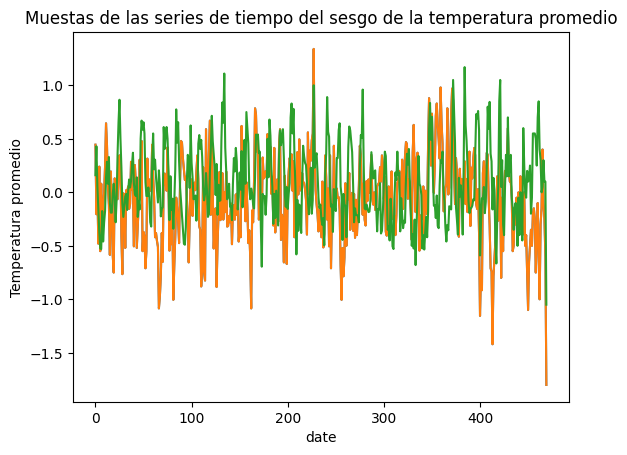

In [51]:
# Plot a few time series
for index in [0,1,2]:
    plt.plot(tavg_features[index,:,0])

plt.xlabel("date")
plt.ylabel("Temperatura promedio")
plt.title("Muestas de las series de tiempo del sesgo de la temperatura promedio")
plt.show()

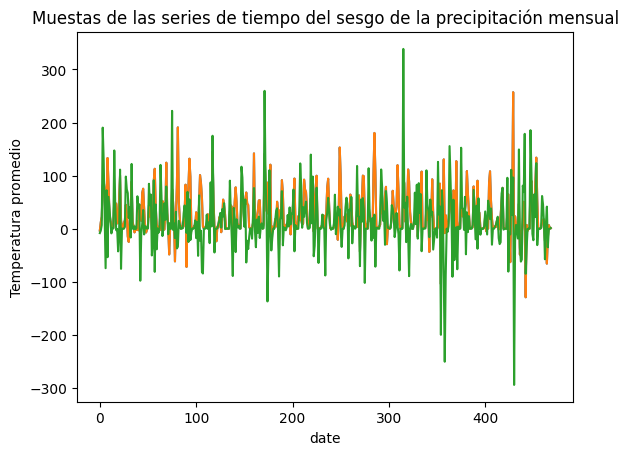

In [232]:
# Plot a few time series
for index in [0,1,2]:
    plt.plot(ppt_features[index,:,0])

plt.xlabel("date")
plt.ylabel("Temperatura promedio")
plt.title("Muestas de las series de tiempo del sesgo de la precipitación mensual")
plt.show()

In [52]:
# Autocorrelation computation
# From https://github.com/fjxmlzn/DoppelGANger/issues/20#issuecomment-858234890
EPS = 1e-8

def autocorr(X, Y):
    Xm = torch.mean(X, 1).unsqueeze(1)
    Ym = torch.mean(Y, 1).unsqueeze(1)
    r_num = torch.sum((X - Xm) * (Y - Ym), 1)
    r_den = torch.sqrt(torch.sum((X - Xm)**2, 1) * torch.sum((Y - Ym)**2, 1))

    r_num[r_num == 0] = EPS
    r_den[r_den == 0] = EPS

    r = r_num / r_den
    r[r > 1] = 0
    r[r < -1] = 0

    return r


def get_autocorr(feature):
    feature = torch.from_numpy(feature)
    feature_length = feature.shape[1]
    autocorr_vec = torch.Tensor(feature_length - 2)

    for j in range(1, feature_length - 1):
        autocorr_vec[j - 1] = torch.mean(autocorr(feature[:, :-j],
                                                  feature[:, j:]))

    return autocorr_vec.cpu().detach().numpy()

<h2 style="color:red;"> 📚 Training models </h2>

In [217]:
# Train DGAN model
# https://github.com/gretelai/gretel-synthetics/issues/151
config1 = DGANConfig(
    max_sequence_len=tavg.shape[1] - 3,
    sample_len=10,
    use_attribute_discriminator=True,
    gradient_penalty_coef=10.0,
    attribute_gradient_penalty_coef=10.0,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    attribute_discriminator_learning_rate=1e-4,
    attribute_loss_coef=1.0,
    apply_feature_scaling=False,  # features are already scaled to [-1,1]
    apply_example_scaling=True,
    normalization=Normalization.MINUSONE_ONE,
    batch_size=1000,
    epochs=400,
)

tavg_model1 = DGAN(config=config1)

start_time = time.time()
#tavg_model1.train_numpy(
#    features=tavg_features,
#    feature_types=[OutputType.CONTINUOUS] * 1,
#)

#tavg_model1.train_numpy(
#    features=tavg_features,
#    feature_types=[OutputType.CONTINUOUS] * 1,
#    attributes = tavg_attributes
#)

tavg_model1.train_dataframe(
    df=tavg,
    attribute_columns=["altitud", "lon", "lat"],
    discrete_columns=["altitud", "lon", "lat"],
)

# Generate data
synthetic1 = tavg_model1.generate_dataframe(10000)

# Generate data
#synthetic1 = tavg_model1.generate_numpy(10000)

end_time = time.time()

/home/fm/anaconda3/envs/d2l_fw/lib/python3.8/site-packages/gretel_synthetics/timeseries_dgan/transformations.py:224: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self._mode = mode(column).mode[0]
/home/fm/anaconda3/envs/d2l_fw/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/home/fm/anaconda3/envs/d2l_fw/lib/python3.8/site-packages/gretel_synthetics/timeseries_dgan/transformations.py:224: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurt

In [243]:
# Train DGAN model
# https://github.com/gretelai/gretel-synthetics/issues/151
config2 = DGANConfig(
    max_sequence_len=ppt.shape[1] - 2,
    sample_len=7,
    use_attribute_discriminator=True,
    gradient_penalty_coef=10.0,
    attribute_gradient_penalty_coef=10.0,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    attribute_discriminator_learning_rate=1e-4,
    attribute_loss_coef=1.0,
    apply_feature_scaling=False,  # features are already scaled to [-1,1]
    apply_example_scaling=True,
    normalization=Normalization.MINUSONE_ONE,
    batch_size=1000,
    epochs=1000,
)

ppt_model1 = DGAN(config=config2)

start_time = time.time()
#tavg_model1.train_numpy(
#    features=tavg_features,
#    feature_types=[OutputType.CONTINUOUS] * 1,
#)

#tavg_model1.train_numpy(
#    features=tavg_features,
#    feature_types=[OutputType.CONTINUOUS] * 1,
#    attributes = tavg_attributes
#)

ppt_model1.train_dataframe(
    df=ppt,
    attribute_columns=["lon", "lat"],
    discrete_columns=["lon", "lat"],
)

# Generate data
synthetic2 = ppt_model1.generate_dataframe(10000)

# Generate data
#synthetic1 = tavg_model1.generate_numpy(10000)

end_time = time.time()

/home/fm/anaconda3/envs/d2l_fw/lib/python3.8/site-packages/gretel_synthetics/timeseries_dgan/transformations.py:224: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self._mode = mode(column).mode[0]
/home/fm/anaconda3/envs/d2l_fw/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/home/fm/anaconda3/envs/d2l_fw/lib/python3.8/site-packages/gretel_synthetics/timeseries_dgan/transformations.py:224: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurt

In [162]:
print(synthetic1[0].shape)
synthetic1[1].shape

(10000, 1)


(10000, 470, 1)

In [ ]:
# Redimensionar el array para que tenga la forma (10000, 470)
reshape_synthetic1 = np.reshape(synthetic1[1], (synthetic1[1].shape[0], synthetic1[1].shape[1]))
# Crear el dataframe a partir del numpy array
df_synthetic1 = pd.DataFrame(reshape_synthetic1)
column_names = [i for i in tavg.iloc[:, 0:470].columns]
df_synthetic1.columns = column_names
df_synthetic1.head()

In [246]:
nan_counts = synthetic1.isnull().sum(axis=1)
df_nan_counts = pd.DataFrame({'col1':nan_counts})
#df_nan_counts.tail()
(df_nan_counts.groupby('col1')
              .size()
              .reset_index(name='Count')
              .rename(columns={'col1':'Col_value'})
)

,Col_value,Count
0,0,2509
1,1,3277
2,2,2457
3,3,1757


In [247]:
nan_counts = synthetic2.isnull().sum(axis=1)
df_nan_counts = pd.DataFrame({'col1':nan_counts})
#df_nan_counts.tail()
(df_nan_counts.groupby('col1')
              .size()
              .reset_index(name='Count')
              .rename(columns={'col1':'Col_value'})
)

,Col_value,Count
0,0,1611
1,1,3733
2,2,4656


In [206]:
#synthetic2 = synthetic1.dropna()

In [248]:
# Extract numpy arrays for charts
#tavg_synthetic_attributes1 = synthetic1[["altitud"]].to_numpy().astype("int")
#print(tavg_synthetic_attributes1.shape)
ppt_synthetic_features1 = np.expand_dims(synthetic2.iloc[:,3:].to_numpy(), axis=-1)
print(ppt_synthetic_features1.shape)

(10000, 468, 1)


In [249]:
ppt_synthetic_acf = get_autocorr(np.nan_to_num(ppt_synthetic_features1, nan=0.0))
ppt_acf = get_autocorr(ppt_features)

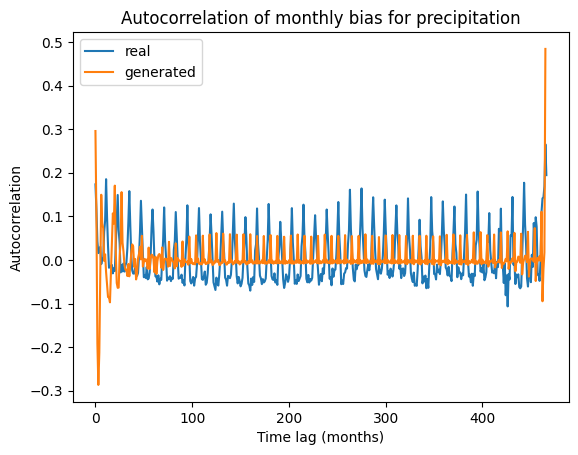

In [250]:
# Figure 1, autocorrelation
plt.plot(ppt_acf, label="real")
plt.plot(ppt_synthetic_acf, label="generated")
plt.xlabel("Time lag (months)")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of monthly bias for precipitation")
plt.legend()
plt.show()

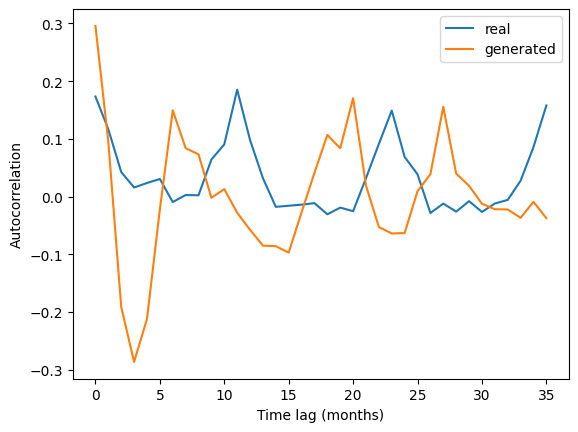

In [251]:
# Zoom in on first 30 months lags of autocorrelation
plt.plot(ppt_acf[0:36], label="real")
plt.plot(ppt_synthetic_acf[0:36], label="generated")
plt.xlabel("Time lag (months)")
plt.ylabel("Autocorrelation")
plt.legend()
plt.show()

In [219]:
# Extract numpy arrays for charts
#tavg_synthetic_attributes1 = synthetic1[["altitud"]].to_numpy().astype("int")
#print(tavg_synthetic_attributes1.shape)
tavg_synthetic_features1 = np.expand_dims(synthetic1.iloc[:,3:].to_numpy(), axis=-1)
print(tavg_synthetic_features1.shape)

(10000, 470, 1)


In [220]:
tavg_synthetic_acf1 = get_autocorr(np.nan_to_num(tavg_synthetic_features1, nan=0.0))
tavg_acf = get_autocorr(tavg_features)

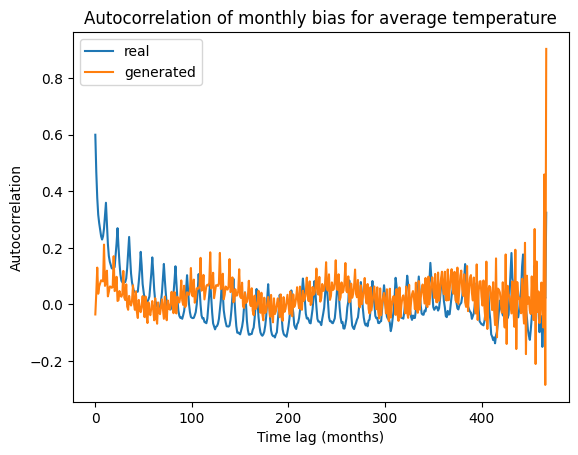

In [244]:
# Figure 1, autocorrelation
plt.plot(tavg_acf, label="real")
plt.plot(tavg_synthetic_acf1, label="generated")
plt.xlabel("Time lag (months)")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of monthly bias for average temperature")
plt.legend()
plt.show()

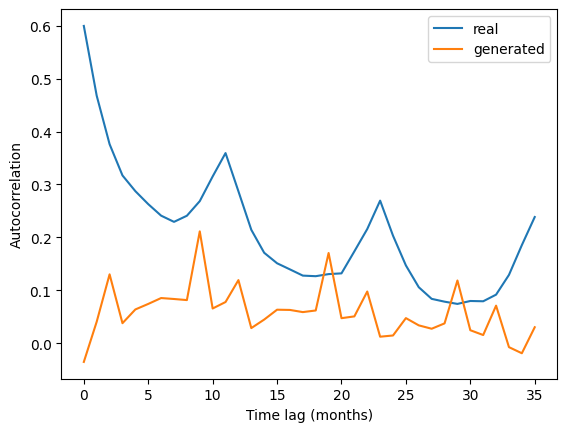

In [245]:
# Zoom in on first 30 months lags of autocorrelation
plt.plot(tavg_acf[0:36], label="real")
plt.plot(tavg_synthetic_acf1[0:36], label="generated")
plt.xlabel("Time lag (months)")
plt.ylabel("Autocorrelation")
plt.legend()
plt.show()

# Referencias 

+ [Using GANs for Sharing Networked Time Series Data: Challenges, Initial Promise, and Open Questions](https://doi.org/10.1145/3419394.3423643)
+ [Generate synthetic time-series data with open-source tools](https://www.kdnuggets.com/2022/06/generate-synthetic-timeseries-data-opensource-tools.html)
+ [Github repo gretel-synthetics](https://github.com/gretelai/gretel-synthetics)